In [205]:
import torch 
import numpy as np 
from matplotlib import pyplot as plt 
import pandas as pd 
import torch_geometric as pyg 
import seaborn as sbn
import networkx as nx 
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
import pickle as pkl 
from sklearn.metrics import r2_score
from adjustText import adjust_text

import sys 
sys.path.append('../')
import src.models.utils as utils
from src.data.LincsDataset import LincsDataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
gsnn_path = '../output/exp1/GSNN1/145a569d-ad85-4093-b632-f46fece8ac5f/model-100.pt'
#nn_path = '../output/exp1/NN1/0ec8c9a8-8bd1-45d5-8f3a-f755bcb3c410/model-100.pt'
nn_path = '../output/exp1/NN1/2300102d-04cc-433f-bcf9-502e1c89a9ae/model-100.pt'
data_path = '../output/exp1/proc/'

In [104]:
gsnn = torch.load(gsnn_path)
nn = torch.load(nn_path)

In [38]:
siginfo = pd.read_csv('../../data/siginfo_beta.txt', sep='\t')
siginfo.head(3)

/tmp/ipykernel_8363/931674393.py:1: DtypeWarning: Columns (0,3,4,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  siginfo = pd.read_csv('../../data/siginfo_beta.txt', sep='\t')


,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
0,b17,NaN,100.0,ug/ml,100 ug/ml,336 h,336.0,h,N8,BRD-U44432129,...,NAMEC8,H05|H06|H07|H08,MET001_N8_XH_X1_B17,MET001_N8_XH_X1_B17:H05|MET001_N8_XH_X1_B17:H0...,NaN,MET,BRD-U44432129,0,0.0,0.0
1,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,A549,BRD-K81418486,...,A549,L04|L08|L12,ABY001_A549_XH_X1_B15,ABY001_A549_XH_X1_B15:L04|ABY001_A549_XH_X1_B1...,NaN,ABY,vorinostat,0,1.0,0.0
2,b15,2.5,2.5,uM,2.5 uM,24 h,24.0,h,HT29,BRD-K70511574,...,HT29,E18|E22,ABY001_HT29_XH_X1_B15,ABY001_HT29_XH_X1_B15:E18|ABY001_HT29_XH_X1_B1...,NaN,ABY,HMN-214,0,1.0,0.0


In [162]:
data = torch.load(data_path + '/Data.pt')
test_ids = np.load(data_path + '/lincs_test_obs.npy', allow_pickle=True).tolist() + np.load(data_path + '/lincs_val_obs.npy', allow_pickle=True).tolist()
test_dataset = LincsDataset(data_path, test_ids, data, null_inflation=0.)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=8)

In [163]:
y, yhat, sig_ids = utils.predict_gsnn(test_loader, gsnn, data, device='cuda', return_omics=False)

In [164]:
y2, yhat2, sig_ids2 = utils.predict_nn(test_loader, nn, data, device='cuda')

# Performance by `observation`

In [274]:
#gsnn_obs_r2 = r2_score(y.T, yhat.T, multioutput='raw_values')
#nn_obs_r2 = r2_score(y2.T, yhat2.T, multioutput='raw_values')

gsnn_obs_r = utils.corr_score(y.T, yhat.T, multioutput='raw_values')
nn_obs_r = utils.corr_score(y2.T, yhat2.T, multioutput='raw_values')

#gsnn_obs_mse = ((y-yhat)**2).mean(axis=1)
#nn_obs_mse = ((y2-yhat2)**2).mean(axis=1)

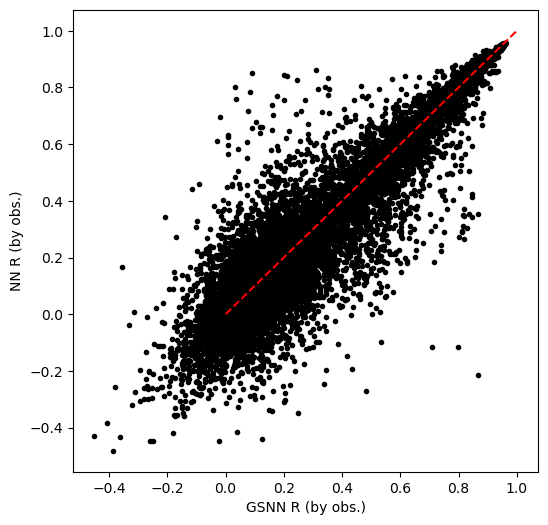

In [312]:
plt.figure(figsize=(6,6))
plt.plot(gsnn_obs_r, nn_obs_r, 'k.', alpha=1.)
#plt.xlim(-1,1)
#plt.xlim(0,10)
#plt.ylim(-1,1)
#plt.ylim(0,10)
plt.xlabel('GSNN R (by obs.)')
plt.ylabel('NN R (by obs.)')
plt.plot((0,1), (0,1), 'r--')
plt.show()

# Performance by `drug`

In [293]:
siginfo2 = pd.DataFrame({'sig_id':sig_ids}).merge(siginfo, on='sig_id', how='left').reset_index()
siginfo2.shape

(15177, 38)

In [294]:
druginfo = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')
druginfo.head()

,pert_id,cmap_name,target,moa,canonical_smiles,inchi_key,compound_aliases
0,BRD-A08715367,L-theanine,NaN,NaN,CCNC(=O)CCC(N)C(O)=O,DATAGRPVKZEWHA-UHFFFAOYSA-N,l-theanine
1,BRD-A12237696,L-citrulline,NaN,NaN,NC(CCCNC(N)=O)C(O)=O,RHGKLRLOHDJJDR-UHFFFAOYSA-N,l-citrulline
2,BRD-A18795974,BRD-A18795974,NaN,NaN,CCCN(CCC)C1CCc2ccc(O)cc2C1,BLYMJBIZMIGWFK-UHFFFAOYSA-N,7-hydroxy-DPAT
3,BRD-A27924917,BRD-A27924917,NaN,NaN,NCC(O)(CS(O)(=O)=O)c1ccc(Cl)cc1,WBSMZVIMANOCNX-UHFFFAOYSA-N,2-hydroxysaclofen
4,BRD-A35931254,BRD-A35931254,NaN,NaN,CN1CCc2cccc-3c2C1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-UHFFFAOYSA-N,r(-)-apomorphine


In [304]:
_min_obs_per_drug = 25

failed = 0
drug_res = {'pert_id':[], 'gsnn_r':[], 'nn_r':[], 'gsnn_r2':[], 'nn_r2':[]}
drugspace = siginfo2.pert_id.unique()
for i,pert_id in enumerate(drugspace): 
    print(f'progress: {i}/{len(drugspace)}', end='\r')
    tmp = siginfo2[lambda x: x.pert_id == pert_id]
    idx = tmp.index
    if len(idx) > _min_obs_per_drug: 
        drug_res['pert_id'].append(pert_id)
        drug_res['gsnn_r'].append(utils.corr_score(y[idx], yhat[idx]))
        drug_res['gsnn_r2'].append(r2_score(y[idx], yhat[idx]))
        drug_res['nn_r'].append(utils.corr_score(y2[idx], yhat2[idx]))
        drug_res['nn_r2'].append(r2_score(y2[idx], yhat2[idx]))
    else: 
        failed += 1

print() 
print('# failed:', failed)

drug_res = pd.DataFrame(drug_res)
drug_res.head()

progress: 316/317
# failed: 141


,pert_id,gsnn_r,nn_r,gsnn_r2,nn_r2
0,BRD-K88510285,0.385468,0.371977,-0.143033,-0.088082
1,BRD-K00317371,0.164451,0.061266,-0.051158,-0.091572
2,BRD-K60219430,0.097792,0.060261,-0.046003,-0.066494
3,BRD-K90195324,0.159030,0.165735,-0.088263,-0.111631
4,BRD-K27305650,0.174868,0.069254,-0.032496,-0.052612


In [305]:
drug_res = drug_res.merge(druginfo[['pert_id', 'cmap_name']].drop_duplicates(), on='pert_id', how='left')


In [306]:
drug_res = drug_res.assign(diff = lambda x: x.gsnn_r - x.nn_r)

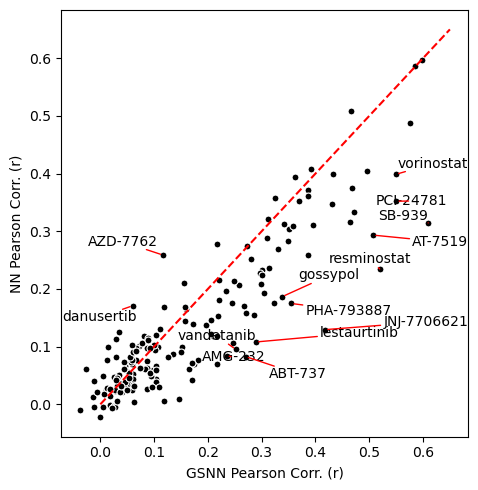

In [365]:
f,ax = plt.subplots(1,1, figsize=(5,5))
sbn.scatterplot(x='gsnn_r', y='nn_r', data=drug_res, c='k', marker='.', s=100)
plt.plot((0,0.65), (0,0.65), 'r--')

annotations = []
for i, row in drug_res[lambda x: (x['diff'] > 0.15) | (x['diff'] < -0.1)].iterrows(): 
    annotations.append(ax.annotate(row.cmap_name, (row.gsnn_r, row.nn_r)))#, textcoords='offset points', arrowprops=dict(arrowstyle='-', color='r')))

plt.tight_layout() 
_npts = 100
adjust_text(annotations, 
            x=np.linspace(0,1,_npts), 
            y=np.linspace(0,1,_npts) + 0.1*np.random.randn(_npts), 
            arrowprops=dict(arrowstyle='-', color='red'), 
            avoid_self=True, 
            expand_points=(2.,2.75), 
            lim=2000)

ax.set_xlabel('GSNN Pearson Corr. (r)')
ax.set_ylabel('NN Pearson Corr. (r)')
plt.show()

# performance by `gene`

In [170]:
#geneinfo = pd.read_csv('../../data/geneinfo_beta.txt', sep='\t')
#geneinfo.head()

uni2symb = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t').rename({'From':'uniprot', 'To':'gene_symbol'}, axis=1)
uni2symb.head()

,uniprot,gene_symbol
0,Q8NEM1,ZNF680
1,Q9Y496,KIF3A
2,Q6ZWJ1,STXBP4
3,Q8TAM1,BBS10
4,A0A0J9YXM7,TRBJ1-5


In [171]:
gsnn_gene_r = utils.corr_score(y, yhat, multioutput='raw_values')
nn_gene_r = utils.corr_score(y2, yhat2, multioutput='raw_values')
gene_names = [x.split('__')[1] for x in data.node_names[data.output_node_mask]]
gene_res = pd.DataFrame({'uniprot':gene_names, 'gsnn_r':gsnn_gene_r, 'nn_r':nn_gene_r})
gene_res = gene_res.merge(uni2symb, on='uniprot', how='left')
gene_res.head()

,uniprot,gsnn_r,nn_r,gene_symbol
0,O00180,0.555420,0.524437,KCNK1
1,O00206,0.316298,0.300493,TLR4
2,O00214,0.544742,0.524293,LGALS8
3,O00233,0.593153,0.600753,PSMD9
4,O00273,0.709371,0.697983,DFFA


In [172]:
gene_res.assign(diff = lambda x: x.gsnn_r - x.nn_r).sort_values('diff', ascending=False).head(10)

,uniprot,gsnn_r,nn_r,gene_symbol,diff
33,O60239,0.502175,0.372021,SH3BP5,0.130155
282,Q07812,0.337094,0.219580,BAX,0.117514
329,Q15022,0.519267,0.412795,SUZ12,0.106472
75,P01584,0.418889,0.317253,IL1B,0.101636
223,P48431,0.521616,0.424483,SOX2,0.097133
222,P47736,0.580198,0.486321,RAP1GAP,0.093878
449,Q9Y6P5,0.397294,0.304680,SESN1,0.092614
173,P25445,0.483699,0.391623,FAS,0.092077
90,P04899,0.605811,0.516358,GNAI2,0.089453
396,Q99570,0.564232,0.476429,PIK3R4,0.087803


In [270]:
# for GSEA 
gene_res.assign(diff = lambda x: x.gsnn_r - x.nn_r).sort_values('diff', ascending=False)[['gene_symbol', 'diff']].to_csv('../output/gene_res.tsv', sep='\t', index=False)

In [273]:
_ = [print(x) for x in gene_res.assign(diff = lambda x: x.gsnn_r - x.nn_r).sort_values('diff', ascending=False).gene_symbol[:50].values.tolist()]

SH3BP5
BAX
SUZ12
IL1B
SOX2
RAP1GAP
SESN1
FAS
GNAI2
PIK3R4
CDKN2A
MYC
HDAC2
CDC25A
HOXA10
SCARB1
PTK2B
CCL2
NOS3
NCOA3
CREG1
CTNND1
TLCD3A
RPA1
EZH2
GPC1
INSIG1
PPARD
CTSD
EGR1
CDK6
RFC2
DNMT1
CDK5R1
NOLC1
GRN
MTA1
PRKCD
CHEK1
EGF
COL1A1
TFAP2A
DCTD
PTGS2
KIT
EIF4EBP1
MMP2
CASP2
PCK2
VGLL4


In [237]:
gene_res = gene_res.assign(diff = lambda x: x.gsnn_r - x.nn_r).sort_values('diff', ascending=False)

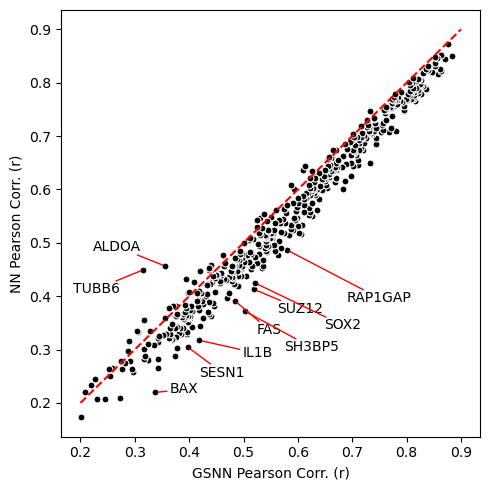

In [326]:
f,ax = plt.subplots(1,1, figsize=(5,5))
sbn.scatterplot(x='gsnn_r', y='nn_r', data=gene_res, c='k', marker='.', s=100)
plt.plot((0.2,0.9), (0.2,0.9), 'r--')

annotations = []
for i, row in gene_res[lambda x: (x['diff'] > 0.09) | (x['diff'] < -0.09)].iterrows(): 
    annotations.append(ax.annotate(row.gene_symbol, (row.gsnn_r, row.nn_r)))#, textcoords='offset points',arrowprops=dict(arrowstyle='-', color='r')))

plt.tight_layout() 
adjust_text(annotations, x=gene_res.gsnn_r.values.tolist(), y=gene_res.nn_r.values.tolist(), arrowprops=dict(arrowstyle='-', color='red'), avoid_self=True, expand_points=(2.,2.75), lim=2000)

ax.set_xlabel('GSNN Pearson Corr. (r)')
ax.set_ylabel('NN Pearson Corr. (r)')
plt.show()

# Performance by `drug target`

In [177]:
druginfo = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')
druginfo.head()

,pert_id,cmap_name,target,moa,canonical_smiles,inchi_key,compound_aliases
0,BRD-A08715367,L-theanine,NaN,NaN,CCNC(=O)CCC(N)C(O)=O,DATAGRPVKZEWHA-UHFFFAOYSA-N,l-theanine
1,BRD-A12237696,L-citrulline,NaN,NaN,NC(CCCNC(N)=O)C(O)=O,RHGKLRLOHDJJDR-UHFFFAOYSA-N,l-citrulline
2,BRD-A18795974,BRD-A18795974,NaN,NaN,CCCN(CCC)C1CCc2ccc(O)cc2C1,BLYMJBIZMIGWFK-UHFFFAOYSA-N,7-hydroxy-DPAT
3,BRD-A27924917,BRD-A27924917,NaN,NaN,NCC(O)(CS(O)(=O)=O)c1ccc(Cl)cc1,WBSMZVIMANOCNX-UHFFFAOYSA-N,2-hydroxysaclofen
4,BRD-A35931254,BRD-A35931254,NaN,NaN,CN1CCc2cccc-3c2C1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-UHFFFAOYSA-N,r(-)-apomorphine


In [178]:
_min_obs_per_drug = 25

failed = 0
targ_res = {'target':[], 'gsnn_r':[], 'nn_r':[], 'num_drugs':[], 'num_obs':[]}
targspace = druginfo.target.unique()
for i,targ in enumerate(targspace): 
    print(f'progress: {i}/{len(targspace)}', end='\r')
    drugs_with_targ = druginfo[lambda x: x.target == targ].pert_id.unique().tolist()
    tmp = siginfo2[lambda x: x.pert_id.isin(drugs_with_targ)]
    idx = tmp.index
    if len(idx) > _min_obs_per_drug: 
        targ_res['target'].append(targ)
        targ_res['gsnn_r'].append(utils.corr_score(y[idx], yhat[idx]))
        targ_res['nn_r'].append(utils.corr_score(y2[idx], yhat2[idx]))
        targ_res['num_drugs'].append(len(drugs_with_targ))
        targ_res['num_obs'].append(len(idx))
    else: 
        failed += 1

print() 
print('# failed:', failed)

targ_res = pd.DataFrame(targ_res)
targ_res.head()

progress: 890/891
# failed: 734


,target,gsnn_r,nn_r,num_drugs,num_obs
0,AKT3,0.154562,0.212528,7,103
1,AKT1,0.168569,0.230471,10,206
2,AKT2,0.154562,0.212528,7,103
3,MTOR,0.324980,0.255637,36,1359
4,BCL2,0.307112,0.275586,10,297


In [199]:
# for GSEA 
targ_res.assign(diff = lambda x: x.gsnn_r - x.nn_r).sort_values('diff', ascending=False).head(50)

,target,gsnn_r,nn_r,num_drugs,num_obs,diff
112,HDAC5,0.551722,0.360241,5,99,0.191481
118,HDAC4,0.551722,0.360241,6,99,0.191481
117,HDAC9,0.551722,0.360241,5,99,0.191481
56,BCL2L2,0.247330,0.083046,2,135,0.164284
24,HDAC3,0.562590,0.398635,10,409,0.163955
61,CDK6,0.481513,0.322874,4,171,0.158639
109,PTK6,0.251932,0.095105,1,118,0.156828
116,HDAC10,0.571392,0.416094,6,128,0.155297
115,HDAC11,0.500146,0.358665,4,34,0.141481
65,PYGM,0.472540,0.333619,1,110,0.138921


In [180]:
#_ = [print(x) for x in targ_res.assign(diff = lambda x: x.gsnn_r - x.nn_r).sort_values('diff', ascending=False).head(20).target.values.tolist()]

In [181]:
#_ = [print(x) for x in targ_res.assign(diff = lambda x: x.gsnn_r - x.nn_r).sort_values('diff', ascending=False).target.unique().tolist()]

In [200]:
targ_res = targ_res.assign(diff = lambda x: x.gsnn_r - x.nn_r).sort_values('diff', ascending=False)

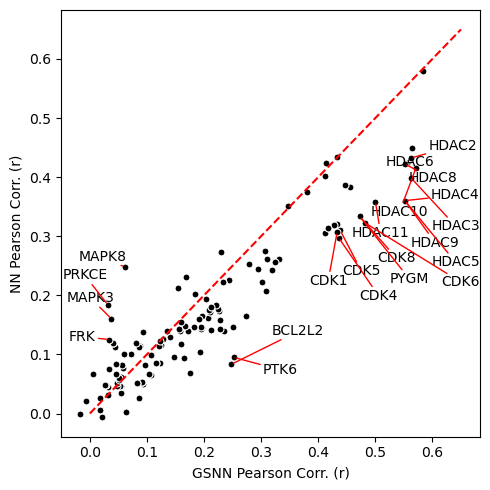

In [356]:
f,ax = plt.subplots(1,1, figsize=(5,5))
sbn.scatterplot(x='gsnn_r', y='nn_r', data=targ_res, c='k', marker='.', s=100)
plt.plot((0,0.65), (0,0.65), 'r--')

annotations = []
for i, row in targ_res[lambda x: (x['diff'] > 0.12) | (x['diff'] < -0.08)].iterrows(): 
    annotations.append(ax.annotate(row.target, (row.gsnn_r, row.nn_r)))#, textcoords='offset points', arrowprops=dict(arrowstyle='-', color='r')))

plt.tight_layout() 
_npts = 500
adjust_text(annotations, 
            x=np.linspace(0,1,_npts), 
            y=np.linspace(0,1,_npts) + 0.05*np.random.randn(_npts), 
            arrowprops=dict(arrowstyle='-', color='red'), 
            avoid_self=True, expand_points=(2.,2.75), 
            lim=2000)

ax.set_xlabel('GSNN Pearson Corr. (r)')
ax.set_ylabel('NN Pearson Corr. (r)')
plt.show()

# Performance by `drug moa`

In [184]:
_min_obs_per_drug = 25

failed = 0
moa_res = {'moa':[], 'gsnn_r':[], 'nn_r':[], 'num_drugs':[], 'num_obs':[]}
moaspace = druginfo.moa.unique()
for i, moa in enumerate(moaspace): 
    print(f'progress: {i}/{len(moaspace)}', end='\r')
    drugs_with_moa = druginfo[lambda x: x.moa == moa].pert_id.unique().tolist()
    tmp = siginfo2[lambda x: x.pert_id.isin(drugs_with_moa)]
    idx = tmp.index
    if len(idx) > _min_obs_per_drug: 
        moa_res['moa'].append(moa)
        moa_res['gsnn_r'].append(utils.corr_score(y[idx], yhat[idx]))
        moa_res['nn_r'].append(utils.corr_score(y2[idx], yhat2[idx]))
        moa_res['num_drugs'].append(len(drugs_with_targ))
        moa_res['num_obs'].append(len(idx))
    else: 
        failed += 1

print() 
print('# failed:', failed)

moa_res = pd.DataFrame(moa_res)
moa_res.head()

progress: 657/658
# failed: 577


,moa,gsnn_r,nn_r,num_drugs,num_obs
0,ALK inhibitor,0.071701,0.100883,1,146
1,Akt inhibitor,0.168620,0.210618,1,230
2,BCL inhibitor,0.302436,0.232665,1,295
3,CDK inhibitor,0.428367,0.322230,1,589
4,CHK inhibitor,0.232974,0.222816,1,95


In [185]:
moa_res.assign(diff = lambda x: x.gsnn_r - x.nn_r).sort_values('diff', ascending=False).head(10)

,moa,gsnn_r,nn_r,num_drugs,num_obs,diff
58,Cell cycle inhibitor,0.440414,0.313015,1,95,0.127400
13,HDAC inhibitor,0.564407,0.452732,1,972,0.111675
3,CDK inhibitor,0.428367,0.322230,1,589,0.106136
31,RET tyrosine kinase inhibitor,0.223367,0.121049,1,551,0.102317
47,ErbB2 inhibitor,0.169532,0.071572,1,91,0.097960
11,EGFR inhibitor,0.225000,0.129016,1,977,0.095984
8,MDM inhibitor,0.208877,0.122701,1,472,0.086176
27,Phosphodiesterase inhibitor,0.155535,0.074839,1,123,0.080696
28,Estrogen receptor antagonist,0.152471,0.074456,1,297,0.078016
77,DNA dependent protein kinase inhibitor,0.165162,0.094121,1,79,0.071040


In [186]:
moa_res.assign(diff = lambda x: x.gsnn_r - x.nn_r).sort_values('diff', ascending=False).tail(10)

,moa,gsnn_r,nn_r,num_drugs,num_obs,diff
80,3beta-hydroxy-delta5-steroid dehydrogenase inh...,0.057104,0.082529,1,30,-0.025425
57,ATM kinase inhibitor,0.061500,0.089446,1,131,-0.027946
50,RAD51 inhibitor,0.077848,0.105960,1,54,-0.028112
0,ALK inhibitor,0.071701,0.100883,1,146,-0.029183
43,STAT inhibitor,0.033892,0.075330,1,65,-0.041438
1,Akt inhibitor,0.168620,0.210618,1,230,-0.041998
54,Mitotic inhibitor,0.117799,0.167882,1,28,-0.050083
53,Caspase inhibitor,0.024426,0.091173,1,57,-0.066747
52,Caspase activator,0.194585,0.317164,1,85,-0.122579
35,JNK inhibitor,0.061861,0.247705,1,53,-0.185844


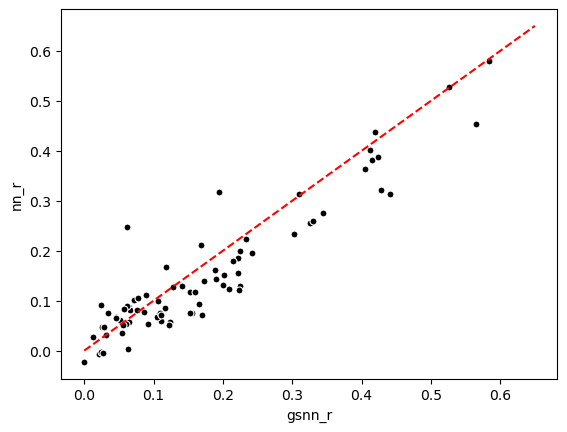

In [187]:
plt.figure() 
sbn.scatterplot(x='gsnn_r', y='nn_r', data=moa_res, c='k', marker='.', s=100)
plt.plot((0,0.65), (0,0.65), 'r--')
plt.show()

# performance by `cell line`

In [188]:
_min_obs_per_drug = 25

failed = 0
cell_res = {'cell_iname':[], 'gsnn_r':[], 'nn_r':[], 'num_obs':[]}
cellspace = siginfo2.cell_iname.unique()
for i, cell in enumerate(cellspace): 
    print(f'progress: {i}/{len(cellspace)}', end='\r')
    tmp = siginfo2[lambda x: x.cell_iname == cell]
    idx = tmp.index
    if len(idx) > _min_obs_per_drug: 
        cell_res['cell_iname'].append(cell)
        cell_res['gsnn_r'].append(utils.corr_score(y[idx], yhat[idx]))
        cell_res['nn_r'].append(utils.corr_score(y2[idx], yhat2[idx]))
        cell_res['num_obs'].append(len(idx))
    else: 
        failed += 1

print() 
print('# failed:', failed)

cell_res = pd.DataFrame(cell_res)
cell_res.head()

progress: 63/64
# failed: 2


,cell_iname,gsnn_r,nn_r,num_obs
0,NCIH1437,0.392228,0.382239,48
1,VCAP,0.405255,0.406643,190
2,YAPC,0.491667,0.485318,784
3,SKES1,0.187997,0.152838,72
4,SH4,0.295887,0.251302,67


In [189]:
cell_res.assign(diff = lambda x: x.gsnn_r - x.nn_r).sort_values('diff', ascending=False).head(10)

,cell_iname,gsnn_r,nn_r,num_obs,diff
30,HEC151,0.476265,0.305438,30,0.170827
19,JURKAT,0.377398,0.219502,318,0.157896
58,HEC1A,0.431280,0.293101,95,0.138179
17,NCIH841,0.451808,0.315206,59,0.136602
44,BICR6,0.393973,0.266397,49,0.127575
55,OVK18,0.511329,0.409200,57,0.102128
40,SKMEL5,0.464252,0.363405,136,0.100847
33,MINO,0.164578,0.064962,68,0.099616
49,COV434,0.319521,0.221103,59,0.098418
46,GP2D,0.373843,0.275731,54,0.098112


In [244]:
cell_res = cell_res.assign(diff = lambda x: x.gsnn_r - x.nn_r).sort_values('diff', ascending=False)

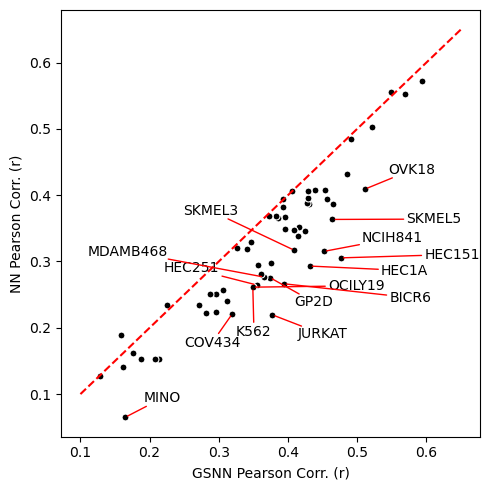

In [330]:
f,ax = plt.subplots(1,1, figsize=(5,5))
sbn.scatterplot(x='gsnn_r', y='nn_r', data=cell_res, c='k', marker='.', s=100)
plt.plot((0.1,0.65), (0.1,0.65), 'r--')

annotations = []
for i, row in cell_res[lambda x: (x['diff'] > 0.08) | (x['diff'] < -0.1)].iterrows(): 
    annotations.append(ax.annotate(row.cell_iname, (row.gsnn_r, row.nn_r)))#, textcoords='offset points',  arrowprops=dict(arrowstyle='-', color='r')))

plt.tight_layout() 
adjust_text(annotations, x=cell_res.gsnn_r.values.tolist(), y=cell_res.nn_r.values.tolist(), arrowprops=dict(arrowstyle='-', color='red'), avoid_self=True, expand_points=(2.,2.75), lim=2000)


ax.set_xlabel('GSNN Pearson Corr. (r)')
ax.set_ylabel('NN Pearson Corr. (r)')
plt.show()

In [248]:
cellinfo = pd.read_csv('../../data/cellinfo_beta.txt', sep='\t')
cellinfo.head()

,cell_iname,cellosaurus_id,donor_age,donor_age_death,donor_disease_age_onset,doubling_time,growth_medium,provider_catalog_id,feature_id,cell_type,donor_ethnicity,donor_sex,donor_tumor_phase,cell_lineage,primary_disease,subtype,provider_name,growth_pattern,ccle_name,cell_alias
0,1HAE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,Unknown,Unknown,Unknown,unknown,unknown,normal fibroblast sample,NaN,unknown,NaN,NaN
1,AALE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,Unknown,Unknown,Unknown,unknown,unknown,normal epithelium sample,NaN,unknown,NaN,NaN
2,AG06263_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tumor,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,NaN
3,AG06840_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tumor,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,NaN
4,AG078N1_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tumor,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,NaN


In [249]:
cell_res = cell_res.merge(cellinfo, on='cell_iname', how='left')
cell_res.head()

,cell_iname,gsnn_r,nn_r,num_obs,diff,cellosaurus_id,donor_age,donor_age_death,donor_disease_age_onset,doubling_time,...,donor_ethnicity,donor_sex,donor_tumor_phase,cell_lineage,primary_disease,subtype,provider_name,growth_pattern,ccle_name,cell_alias
0,HEC151,0.476265,0.305438,30,0.170827,CVCL_2925,NaN,NaN,NaN,60,...,Unknown,F,Primary,endometrium,endometrial cancer,adenocarcinoma,HSRRB,adherent,HEC151_ENDOMETRIUM,HEC-151
1,JURKAT,0.377398,0.219502,318,0.157896,CVCL_0065,NaN,NaN,NaN,25-35,...,Unknown,M,Unknown,haematopoietic_and_lymphoid_tissue,leukemia,acute lymphoblastic leukemia (all),DSMZ,suspension,JURKAT_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,FCCH1024
2,HEC1A,0.431280,0.293101,95,0.138179,CVCL_0293,71,NaN,NaN,48,...,Unknown,F,Unknown,endometrium,endometrial cancer,adenocarcinoma,NaN,adherent,HEC1A_ENDOMETRIUM,HEC-1-A
3,NCIH841,0.451808,0.315206,59,0.136602,CVCL_1595,51,NaN,NaN,96,...,Caucasian,M,Metastatic,lung,lung cancer,small cell lung carcinoma,ATCC,mix,NCIH841_LUNG,NCI-H841|H-841
4,BICR6,0.393973,0.266397,49,0.127575,CVCL_2314,NaN,NaN,NaN,96,...,Caucasian,M,Primary,upper_aerodigestive_tract,head and neck cancer,carcinoma,ECACC,adherent,BICR6_UPPER_AERODIGESTIVE_TRACT,BICR-6|BICR 6


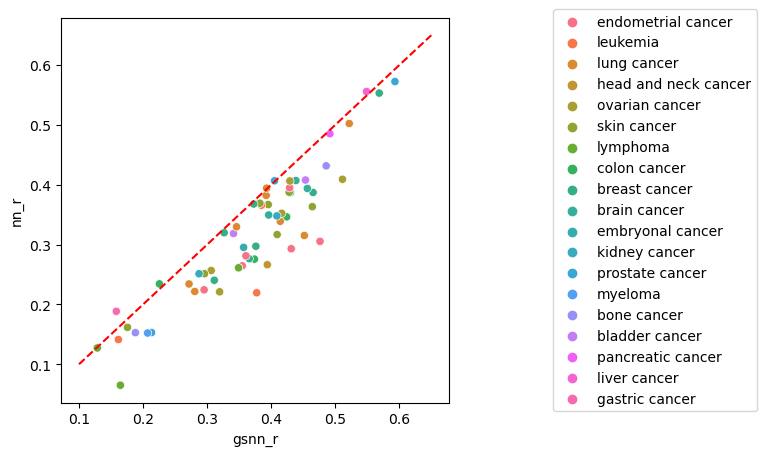

In [252]:
f,ax = plt.subplots(1,1, figsize=(5,5))
g = sbn.scatterplot(x='gsnn_r', y='nn_r', data=cell_res, hue='primary_disease', ax=ax) 
plt.plot((0.1,0.65), (0.1,0.65), 'r--')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

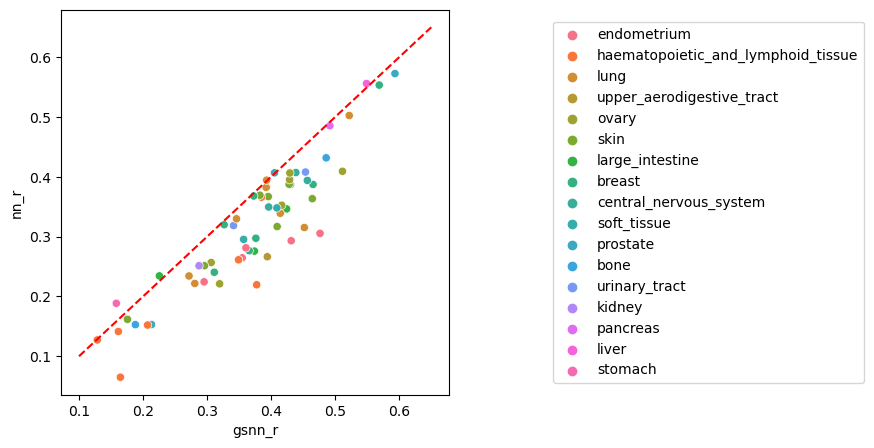

In [253]:
f,ax = plt.subplots(1,1, figsize=(5,5))
g = sbn.scatterplot(x='gsnn_r', y='nn_r', data=cell_res, hue='cell_lineage', ax=ax) 
plt.plot((0.1,0.65), (0.1,0.65), 'r--')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

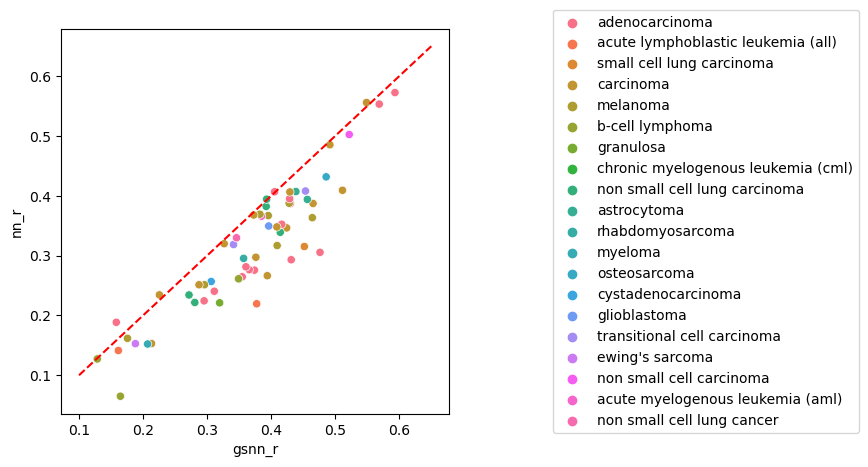

In [254]:
f,ax = plt.subplots(1,1, figsize=(5,5))
g = sbn.scatterplot(x='gsnn_r', y='nn_r', data=cell_res, hue='subtype', ax=ax) 
plt.plot((0.1,0.65), (0.1,0.65), 'r--')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

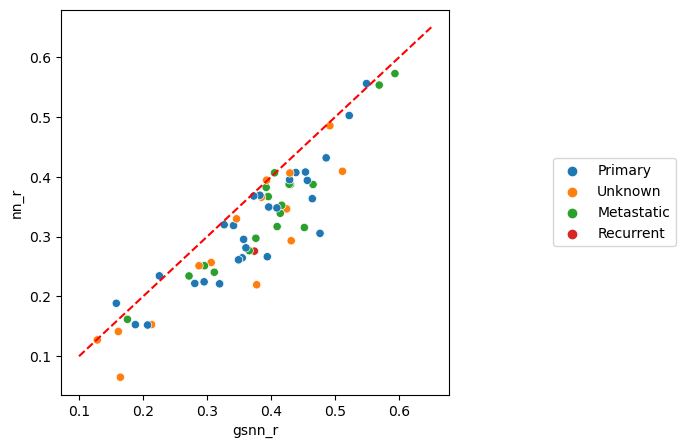

In [256]:
f,ax = plt.subplots(1,1, figsize=(5,5))
g = sbn.scatterplot(x='gsnn_r', y='nn_r', data=cell_res, hue='donor_tumor_phase', ax=ax) 
plt.plot((0.1,0.65), (0.1,0.65), 'r--')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

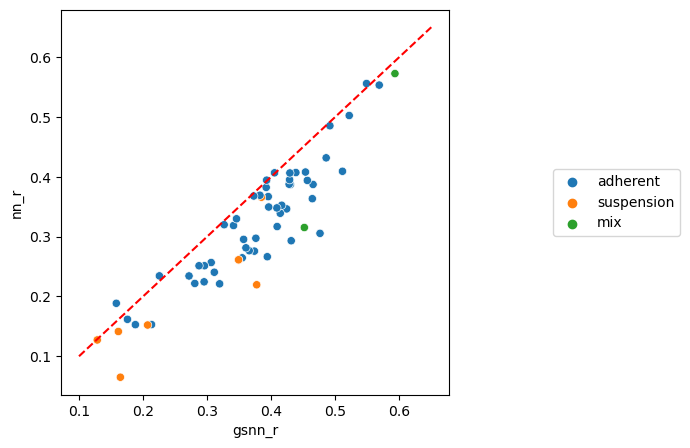

In [257]:
f,ax = plt.subplots(1,1, figsize=(5,5))
g = sbn.scatterplot(x='gsnn_r', y='nn_r', data=cell_res, hue='growth_pattern', ax=ax) 
plt.plot((0.1,0.65), (0.1,0.65), 'r--')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

# performance by `disease`

In [258]:
cellinfo = pd.read_csv('../../data/cellinfo_beta.txt', sep='\t')
cellinfo.head()

,cell_iname,cellosaurus_id,donor_age,donor_age_death,donor_disease_age_onset,doubling_time,growth_medium,provider_catalog_id,feature_id,cell_type,donor_ethnicity,donor_sex,donor_tumor_phase,cell_lineage,primary_disease,subtype,provider_name,growth_pattern,ccle_name,cell_alias
0,1HAE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,Unknown,Unknown,Unknown,unknown,unknown,normal fibroblast sample,NaN,unknown,NaN,NaN
1,AALE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,Unknown,Unknown,Unknown,unknown,unknown,normal epithelium sample,NaN,unknown,NaN,NaN
2,AG06263_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tumor,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,NaN
3,AG06840_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tumor,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,NaN
4,AG078N1_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tumor,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,NaN


In [259]:
_min_obs_per_drug = 25

failed = 0
dis_res = {'disease':[], 'gsnn_r':[], 'nn_r':[], 'num_lines':[], 'num_obs':[]}
disspace = cellinfo.primary_disease.unique()
for i, dis in enumerate(disspace): 
    print(f'progress: {i}/{len(disspace)}', end='\r')
    cells_in_disease = cellinfo[lambda x: x.primary_disease == dis].cell_iname.unique()
    tmp = siginfo2[lambda x: x.cell_iname.isin(cells_in_disease)]
    idx = tmp.index
    if len(idx) > _min_obs_per_drug: 
        dis_res['disease'].append(dis)
        dis_res['gsnn_r'].append(utils.corr_score(y[idx], yhat[idx]))
        dis_res['nn_r'].append(utils.corr_score(y2[idx], yhat2[idx]))
        dis_res['num_lines'].append(len(cells_in_disease))
        dis_res['num_obs'].append(len(idx))
    else: 
        failed += 1

print() 
print('# failed:', failed)

dis_res = pd.DataFrame(dis_res)
dis_res.head()

progress: 26/27
# failed: 8


,disease,gsnn_r,nn_r,num_lines,num_obs
0,leukemia,0.411645,0.332461,10,1100
1,lymphoma,0.275777,0.197422,10,233
2,bone cancer,0.432338,0.382145,4,257
3,lung cancer,0.507966,0.481139,28,2142
4,prostate cancer,0.595475,0.575896,6,2462


In [260]:
dis_res.assign(diff = lambda x: x.gsnn_r - x.nn_r).sort_values('diff', ascending=False).head(10)

,disease,gsnn_r,nn_r,num_lines,num_obs,diff
5,endometrial cancer,0.395166,0.261980,10,428,0.133186
18,head and neck cancer,0.393973,0.266397,1,49,0.127575
0,leukemia,0.411645,0.332461,10,1100,0.079185
1,lymphoma,0.275777,0.197422,10,233,0.078356
15,ovarian cancer,0.449528,0.379617,14,290,0.069911
12,kidney cancer,0.359930,0.296389,2,101,0.063542
16,embryonal cancer,0.356999,0.295392,1,77,0.061607
8,brain cancer,0.444284,0.386411,4,163,0.057872
6,myeloma,0.207061,0.152221,2,110,0.054840
9,colon cancer,0.351159,0.300639,19,297,0.050520


In [264]:
dis_res = dis_res.assign(diff = lambda x: x.gsnn_r - x.nn_r).sort_values('diff', ascending=False)

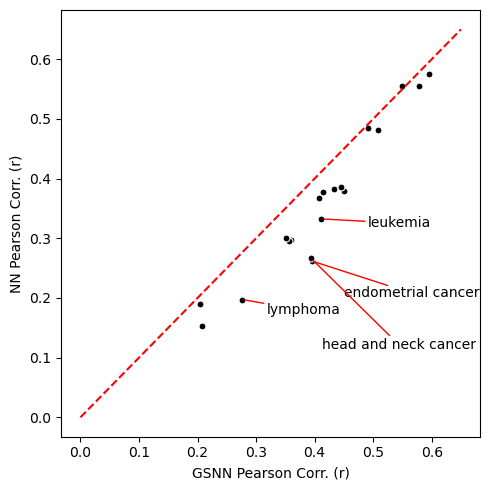

In [352]:
f,ax = plt.subplots(1,1, figsize=(5,5))
sbn.scatterplot(x='gsnn_r', y='nn_r', data=dis_res, c='k', marker='.', s=100)
plt.plot((0,0.65), (0,0.65), 'r--')

annotations = []
for i, row in dis_res[lambda x: (x['diff'] > 0.07) | (x['diff'] < -0.08)].iterrows(): 
    annotations.append(ax.annotate(row.disease, (row.gsnn_r, row.nn_r)))#, textcoords='offset points', arrowprops=dict(arrowstyle='-', color='r')))

plt.tight_layout() 
_npts = 500
adjust_text(annotations, 
            x=np.linspace(0,1,_npts), 
            y=np.linspace(0,1,_npts) + 0.05*np.random.randn(_npts), 
            arrowprops=dict(arrowstyle='-', color='red'), 
            avoid_self=True, expand_points=(2.,2.75), 
            lim=2000)

ax.set_xlabel('GSNN Pearson Corr. (r)')
ax.set_ylabel('NN Pearson Corr. (r)')
plt.show()